PMT Pulse analysis
=======================
A partire dal tutorial: [PMT Pulse analysis](https://straxen.readthedocs.io/en/latest/tutorials/pulse_analysis.html)

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# This just ensures some comments in dataframes below display nicely
import pandas as pd
pd.options.display.max_colwidth = 100

from scipy import stats
import strax
import straxen
from multihist import Histdd, Hist1d

# Print out exactly what versions we are using, for reference / troubleshooting:
import sys
import os.path as osp

In [2]:
st = straxen.contexts.xenonnt_online()

Si usa un background run di XENON1T

In [13]:
#dsets = st.select_runs(available='raw_records', include_tags='sciencerun1', run_mode='background_stable')
#run_id = dsets.name.min()
st.select_runs()

,name,number,mode,start,end,tags,livetime,tags.name,raw_records_available,peak_basics_available
0,007158,7158,xenonnt_commissioning_noise,2020-03-18 17:41:37.343,2020-03-18 17:42:43.982,,00:01:06.639000,NaN,True,False
1,007159,7159,xenonnt_commissioning_noise,2020-03-19 08:37:22.348,2020-03-19 08:38:41.183,,00:01:18.835000,NaN,True,False
2,007160,7160,xenonnt_commissioning_noise,2020-03-19 08:39:17.522,2020-03-19 08:40:48.522,,00:01:31,NaN,False,False
3,007161,7161,xenonnt_commissioning_noise,2020-03-19 08:41:12.806,2020-03-19 08:44:42.178,,00:03:29.372000,NaN,False,False
4,007162,7162,xenonnt_commissioning_pmtgain,2020-03-19 10:47:10.153,2020-03-19 10:50:39.279,messy,00:03:29.126000,NaN,False,False
...,...,...,...,...,...,...,...,...,...,...
1219,008377,8377,xenonnt_selftrigger_commissioning_lowe,2020-06-25 04:41:49.171,2020-06-25 05:41:50.557,,01:00:01.386000,NaN,False,False
1220,008378,8378,xenonnt_selftrigger_commissioning_lowe,2020-06-25 05:42:19.663,2020-06-25 06:42:20.023,,01:00:00.360000,NaN,False,False
1221,008379,8379,xenonnt_selftrigger_commissioning_lowe,2020-06-25 06:42:53.139,2020-06-25 07:42:56.376,,01:00:03.237000,NaN,False,False
1222,008380,8380,xenonnt_selftrigger_commissioning_lowe,2020-06-25 07:43:25.485,2020-06-25 08:43:26.914,,01:00:01.429000,NaN,False,False


In [19]:
run_id = '007208'
wf_len_recorded = 98404

Questo run dura un'ora e non si possono caricare tutte le raw waveform data, prendiamo i primi 30 secondi:

RAW RECORDS
======================
Selection dei **raw records**, che sono presi in input del plugin pulse_processing.

In [15]:
st.data_info('raw_records')

,Field name,Data type,Comment
0,time,int64,Start time since unix epoch [ns]
1,length,int32,Length of the interval in samples
2,dt,int16,Width of one sample [ns]
3,channel,int16,Channel/PMT number
4,pulse_length,int32,Length of pulse to which the record belongs (without zero-padding)
5,record_i,int16,Fragment number in the pulse
6,baseline,int16,Baseline determined by the digitizer (if this is supported)
7,data,"('<i2', (110,))",Waveform data in raw ADC counts


Plot dei primi records del run
---------------------------

Si selezionano i record soltanto per i primi 30 secondi del run.

In [24]:
rr = st.get_array(run_id, 'raw_records', seconds_range=(0, 2))
rr_he = st.get_array(run_id, 'raw_records_he', seconds_range=(0, 2))

In [25]:
def plotRecords(rr,nn,llim,rlim,dlim,ulim):
    dt = rr['dt'][0]
    print('run',run_id,'total number of records',rr['data'].shape[0])
    dts = np.arange(0,rr['data'].shape[1]*dt,dt)
    for i in range(nn):
        plt.plot(dts,rr['data'][i],label=f"PMT n. {rr['channel'][i]}")
    plt.legend()
    plt.xlabel("time (ns)", ha='right', x=1)
    plt.ylabel(f"ADC", ha='right', y=1)
    if rlim is not 0: plt.xlim(llim,rlim)
    if ulim is not 0: plt.ylim(dlim,ulim)

run 007208 total number of records 310866


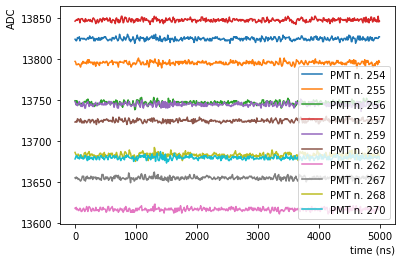

In [26]:
plotRecords(rr,10,400,0,15500,0)

run 007208 total number of records 149523


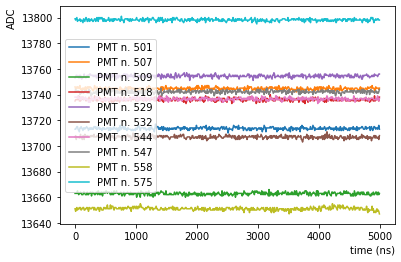

In [28]:
plotRecords(rr_he,10,0,0,0,0)

Sottrazione della baseline
------------------------------

run 007208 total number of records 310866
run 007208 total number of records 310866


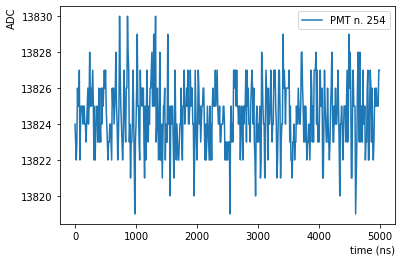

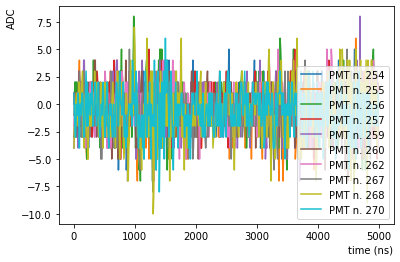

In [59]:
rr0 = strax.raw_to_records(rr)
strax.baseline(rr0)
plt.figure(1)
plotRecords(rr,1,0,0,0,0)
plt.figure(2)
plotRecords(rr0,10,0,0,0,0)

Selezione di record e studio del noise per i primi PMT
-----------------------------------

In [62]:
def plotPMT(rr,id):
    #rrs = rr['data'][(rr['channel'] == id) & (rr['data'].min(1)>1.58e4) & (rr['record_i']==0)] #before baseline substraction
    rrs = rr['data'][(rr['channel'] == id) & (rr['data'].max(1)<10)]# & (rr['record_i']==0)] #before baseline substraction
    nev, rsize = rrs.shape[0], rrs.shape[1]
    print('Total number of events:',nev,'length of pulses:',rsize)
    if nev < 100: return
    dt = rr['dt'][0]
    dts = np.arange(0,rr['data'].shape[1]*dt,dt)
    plt.figure(1)
    #for i in range(nn):
    #plt.plot(dts,rrs[i],label=f"{rr['channel'][i]} L={rr['pulse_length'][i]}")
    plt.plot(dts,rrs[0],label=f"PMT n.{id}")
    plt.title('raw records')
    plt.legend()
    plt.xlabel("time (ns)", ha='right', x=1)
    plt.ylabel(f"ADC", ha='right', y=1)
    
    bsize = 500
    bls = np.zeros([nev,bsize])
    for i in range(nev):
        for j in range(bsize):
            bls[i][j] = rrs[i][j]
    plt.figure(2)
    #for i in range(nn):
    #plt.plot(dts[:bsize],bls[i],label=f"{rr['channel'][i]} L={rr['pulse_length'][i]}")
    plt.plot(dts[:bsize],bls[0],label=f"PMT n.{id}")
    plt.title('raw baselines')
    plt.legend()
    plt.xlabel("time (ns)", ha='right', x=1)
    plt.ylabel(f"ADC", ha='right', y=1)
        
    sampling_rate = 1/(dts[1]-dts[0])*1000
    for i in range(nev):
        fft = np.fft.rfft(bls[i][:])
        abs_fft = np.abs(fft)
        if i is 0: power_spectrum = np.square(abs_fft)
        else: power_spectrum += np.square(abs_fft)
    power_spectrum /= nev
    frequency = np.linspace(0, sampling_rate/2, len(power_spectrum))
    plt.figure(3)
    plt.plot(frequency[1:], power_spectrum[1:],label=f"PMT n.{id}")
    plt.title('Power Spectral Density')
    plt.legend()
    #plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("frequency (MHz)", ha='right', x=1)
    plt.ylabel(f"power spectral density", ha='right', y=1)
    
    #import scipy.signal as signal
    ref = bls.mean(axis=0)
    offset = np.mean(ref[:])
    bl = np.zeros([nev,bsize])
    for i in range(nev):
        bl[i] = bls[i][0:bsize]-np.mean(bls[i][0:bsize])
    noise_matr =  np.matmul(bl.transpose(), bl)/nev
    #noise_matr = signal.convolve2d(noise_matr,np.identity(bsize-fsize+1), boundary='symm', mode='valid')/(bsize-fsize+1)
    
    fig, ax = plt.subplots()
    plt.title(f'PMT n. {id}')
    plt.imshow(noise_matr, cmap='viridis',origin='lower')
    plt.colorbar()

Total number of events: 588 length of pulses: 500
Total number of events: 588 length of pulses: 500
Total number of events: 588 length of pulses: 500
Total number of events: 582 length of pulses: 500
Total number of events: 587 length of pulses: 500
Total number of events: 587 length of pulses: 500
Total number of events: 588 length of pulses: 500
Total number of events: 586 length of pulses: 500
Total number of events: 588 length of pulses: 500
Total number of events: 588 length of pulses: 500


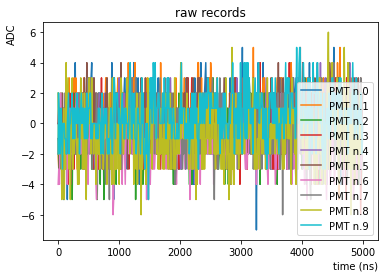

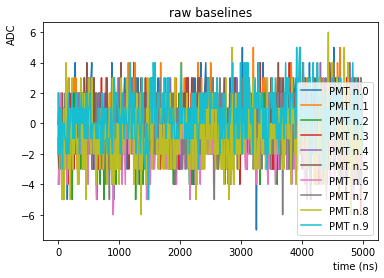

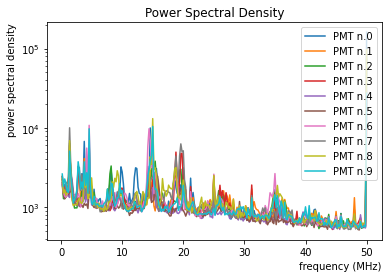

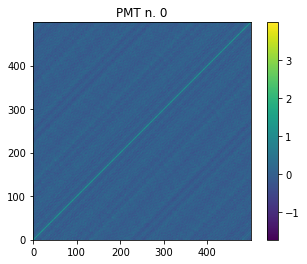

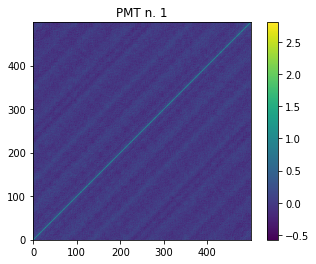

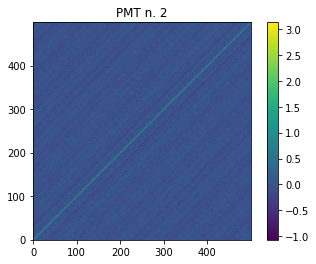

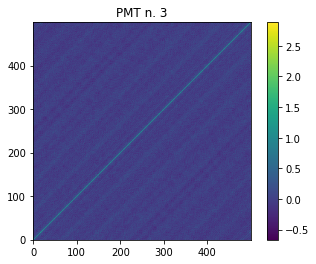

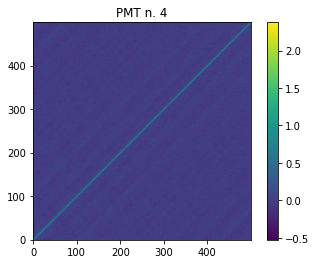

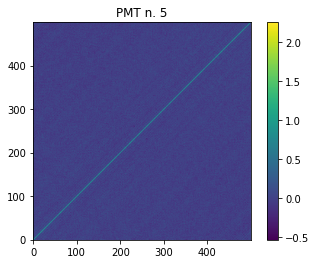

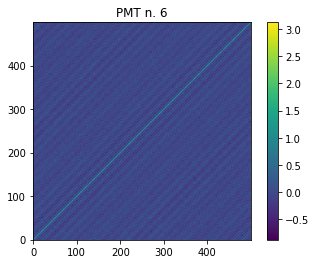

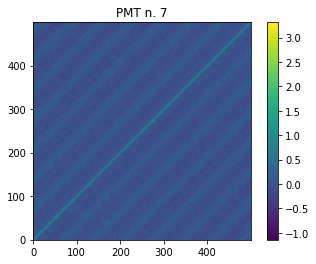

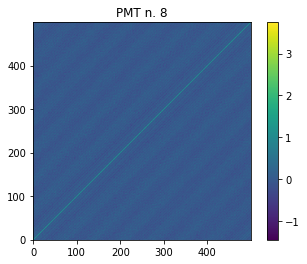

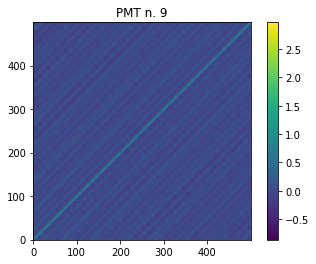

In [63]:
for i in range(10):
    plotPMT(rr0,i)